Imports data - done

Feature Engineer Data - working on 'opening' and then a distance metric for 'AN'.

Split into Training and Holdout sets - 80% Training, 20% Holdout of Overall Dataset.

Split Training into Train/Test sets - 80% Training, 20% Testing of Training Dataset.

Fit model to data - Figure out which model would best be used to evaluate our data.

Tune model - Test hyperparameters to find the most accurate/correct model

Present model data output - relevant charts, accuracy score, etc

In [1]:
try:
    import flaml
except:
    ! pip install -U ipywidgets ipython-autotime plotly scikit-learn dask[dataframe] shap chess
path = {'root':'/kaggle'}
path['in' ] = path['root'] + '/input/chess-games/'
path['out'] = path['root'] + '/working'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 67.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.3/992.3 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.8 MB/s eta 0:00:00
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=dee37209706dc7c75ac08a438f79170ed1f6cae6314342b6ed9bdea1a4b1fb69
  Stored in directory: /root/.cache/pip/wheels/7a/79/8e/0d6e404db9f1e82af2e40b49161d6acab485d75dfb0470ac08
Successfully built chess
  Attempting uninstall: widgetsnbextension
  

In [2]:
##################################################################
### Setup and Read in chess_games
import sklearn as sk, sklearn.base, sklearn.model_selection, sklearn.preprocessing, sklearn.compose, sklearn.ensemble, sklearn.pipeline, sklearn.inspection
import pickle, shap, plotly.express as px, pandas as pd, numpy as np, chess, chess.engine, seaborn as sns, re, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

seed = 42
sk.set_config(transform_output="pandas")
df =  pd.read_csv(path['in'] + 'chess_games.csv')

In [3]:
df.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016.06.30,22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016.06.30,22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016.06.30,22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Correspondence,Jvayne,Wsjvayne,1-0,2016.06.30,22:00:02,1706,1317,27.0,-25.0,A00,Van't Kruijs Opening,-,Normal,1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4,Blitz tournament,kyoday,BrettDale,0-1,2016.06.30,22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...


In [4]:
#Bar plot Defintion

def check_missing_vals(df):
    """
    Generates a report of missing values for each column in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to check for missing values.

    Returns:
        pd.DataFrame: A DataFrame containing columns with missing values and their statistics.
    """
    # Check for null values in each column
    missing_values_report = df.isnull().sum()

    # Create a DataFrame for the missing values report
    missing_values_df = pd.DataFrame({
        'Missing Values': missing_values_report.values,
        'Total Rows': len(df),
        'Missing Percentage': (missing_values_report / len(df)) * 100
    })

    # Filter out columns with no missing values
    columns_with_missing = missing_values_df[missing_values_df['Missing Values'] > 0]

    # Print the table
    print("Missing Values Report:\n")
    if  columns_with_missing.empty:
        #print("No columns have missing values.")
        return "No columns have missing values."
        #print(columns_with_missing.to_string(index=False, float_format="%.2f"))

    # Return the DataFrame for further use if needed
    return columns_with_missing
    
def plot_top_10_levels(df, columns):
    """
    Creates bar plots for the specified columns in the DataFrame, showing only the top 10 levels.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        columns (list): List of columns for which to create bar plots.
    """
    for column in columns:
        # Count the frequency of each level and get the top 10
        top_10 = df[column].value_counts()[:10]

        # Plot the bar chart
        plt.figure(figsize=(17, 10))  # Larger figure for readability
        bars = top_10.plot(kind='bar', color='skyblue', edgecolor='black')

        # Add counts above each bar
        for idx, count in enumerate(top_10.values):
            plt.text(idx, count + count * 0.02, f'{count:,}', ha='center', va='bottom', 
                     fontsize=10, fontweight='bold', color='black')  # Add thousands separator

        # Title and labels
        if len(df[column].unique()) > 10:
            plt.title(f"Top 10 Levels for '{column}' with {len(df[column].unique())} total levels.", fontsize=16, fontweight='bold')
        else:
            plt.title(f"{len(df[column].unique())} Levels of '{column}'", fontsize=16, fontweight='bold')
        plt.ylabel("Frequency", fontsize=14, fontweight='bold')

        # Remove the x-axis label
        plt.xlabel("")

        # Rotate x-ticks for readability
        plt.xticks(rotation=45, ha='right', fontsize=12)

        # Add a grid to improve readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to avoid labels being cut off
        plt.tight_layout()

        # Show the plot
        plt.show()

def analyze_quantitative_column(df, column):
    """
    Analyzes a quantitative column in the DataFrame with the following steps:
    - Plots a histogram or KDE with log transformations if necessary.
    - Computes a six-number summary (min, Q1, Q2/median, Q3, max, mean).
    - Counts the number of missing values.
    - Screens data for potential errors (e.g., negative values or outliers).
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        column (str): The name of the column to analyze.
    """
    # Step 1: Handle missing values
    # missing_count = df[column].isnull().sum()
    # total_count = len(df[column])
    
    # print(f"Analysis for '{column}':")
    # print(f"Total Rows: {total_count}")
    # print(f"Missing Values: {missing_count} ({(missing_count / total_count) * 100:.2f}%)\n")
    
    # Step 2: Compute six-number summary
    summary = df[column].describe(percentiles=[0.25, 0.5, 0.75])
    six_number_summary = pd.DataFrame({
        "Statistic": ["Min", "Q1 (25%)", "Median (Q2)", "Q3 (75%)", "Max", "Mean"],
        "Value": [
            summary['min'],
            summary['25%'],
            summary['50%'],
            summary['75%'],
            summary['max'],
            summary['mean']
        ]
    })
    
    # Print the six-number summary as a table
    print("Six-Number Summary:")
    print(six_number_summary.to_string(index=False, float_format="%.2f"))

    # Step 3: Screen for errors
    potential_errors = df[(df[column] < 0)]
    if not potential_errors.empty:
        print("\nPotential Errors Detected: Negative values found")
    else:
        print("\nNo negative values detected")

    # Step 4: Plot histogram or KDE
    plt.figure(figsize=(12, 8))
    column_data = df[column].dropna()  # Drop missing values for plotting

    if column_data.skew() > 1 or column_data.min() <= 0:
        # Apply log-modulus transform to handle skewness or zero/negative values
        transformed_data = np.sign(column_data) * np.log1p(np.abs(column_data))
        sns.histplot(transformed_data, kde=True, color='skyblue', edgecolor='black')
        plt.title(f"Histogram & KDE for '{column}' (Log-Modulus Transformed)")
        plt.xlabel(f"Log-Modulus Transformed {column}")
    else:
        # Plot without transformation
        sns.histplot(column_data, kde=True, color='skyblue', edgecolor='black')
        plt.title(f"Histogram & KDE for '{column}'")
        plt.xlabel(column)

    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def analyze_quantitative_column_raw(df, column):
    """
    Analyzes a quantitative column in the DataFrame without log transformations.
    - Plots a histogram and KDE of the raw data.
    - Computes a six-number summary (min, Q1, median, Q3, max, mean).
    - Counts the number of missing values.
    - Screens data for potential issues (e.g., negative values or extreme outliers).
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        column (str): The name of the column to analyze.
    """
    column_data = df[column].dropna()
    total_count = len(df[column])
    missing_count = df[column].isnull().sum()

    print(f"Analysis for '{column}':")
    print(f"Total Rows: {total_count}")
    print(f"Missing Values: {missing_count} ({(missing_count / total_count) * 100:.2f}%)\n")

    # Step 1: Summary statistics
    summary = column_data.describe(percentiles=[0.25, 0.5, 0.75])
    six_number_summary = pd.DataFrame({
        "Statistic": ["Min", "Q1 (25%)", "Median (Q2)", "Q3 (75%)", "Max", "Mean"],
        "Value": [
            summary['min'],
            summary['25%'],
            summary['50%'],
            summary['75%'],
            summary['max'],
            summary['mean']
        ]
    })

    print("Six-Number Summary:")
    print(six_number_summary.to_string(index=False, float_format="%.2f"))

    # Step 2: Check for negative values
    if (column_data < 0).any():
        print("\nPotential Issues: Negative values found")
    else:
        print("\nNo negative values detected")

    # Step 3: Histogram + KDE (no transformation)
    plt.figure(figsize=(12, 8))
    sns.histplot(column_data, kde=True, color='cornflowerblue', edgecolor='black')
    plt.title(f"Histogram & KDE for '{column}' (Raw Data)")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
#Translating AN to an aggregate score
from concurrent.futures import ProcessPoolExecutor
# Path to your Stockfish engine (Update this with your actual path)
#STOCKFISH_PATH = "C:/Users/turne/Downloads/stockfish/stockfish.exe"  # Windows example: "C:/stockfish/stockfish.exe"

# Function to evaluate the first 15 moves of a game
def evaluate_game(an_moves, depth=8):
    STOCKFISH_PATH = "/usr/games/stockfish"
    # Load Stockfish engine
    
    engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
    board = chess.Board()  # Start from an empty board
    evaluations = []  # Store evaluation scores
    moves = an_moves.split()  # Limit to first 30 plies (15 full moves)

    for move in an_moves.split():
        try:
            board.push_san(move)  # Make the move
            info = engine.analyse(board, chess.engine.Limit(depth=depth))  # Analyze position
            score = info["score"].relative.score()  # Get Stockfish's evaluation
            evaluations.append(score if score is not None else 0)  # Handle missing scores
        except Exception:
            continue  # Skip invalid moves

    engine.quit()  # Ensure the engine is closed
    return sum(evaluations) / len(evaluations) if evaluations else 0  # Average score

# Load your DataFrame (replace this with your actual DataFrame loading)
# X_train = pd.read_csv("your_dataset.csv")  # Example for loading a dataset

def run_stockfish(df):
    def evaluate_with_print(x, index):
        if index % 100 == 0:
            print(f"Evaluated - {index}/{rows}")
        return evaluate_game(x)

    df['stockfish_eval'] = [evaluate_with_print(an, i) for i, an in enumerate(df['AN'])]

def parse_chess_moves(algebraic_str):
    """
    Parses a string of algebraic chess notation and converts it into a dictionary.
    :param algebraic_str: str, algebraic chess notation (e.g., "1. c4 c3 2. d4 d3")
    :return: dict, {move_number: (white_move, black_move)}
    """
    move_dict = {}
    moves = re.findall(r'\d+\.\s*([\w+#=-]+)\s*([\w+#=-]*)', algebraic_str)
    
    for i, (white, black) in enumerate(moves, start=1):
        move_dict[i] = (white, black if black else None)
    
    return move_dict

def process_dataframe(df, column_name):
    """
    Applies the parse_chess_moves function to a DataFrame column.
    :param df: pandas DataFrame containing chess notation data
    :param column_name: str, name of the column to process
    :return: pandas DataFrame with a new column 'parsed_moves'
    """
    df['parsed_moves'] = df[column_name].apply(parse_chess_moves)
    return df

def reconstruct_chess_moves(parsed_moves, max_moves = 5):
    """
    Reconstructs algebraic notation from a parsed dictionary, truncating at max_moves.
    :param parsed_moves: dict, parsed chess moves
    :param max_moves: int, maximum number of moves to include
    :return: str, reconstructed algebraic notation
    """
    reconstructed = []
    for i in range(1, max_moves + 1):
        if i in parsed_moves:
            white, black = parsed_moves[i]
            move_str = f"{i}. {white}"
            if black:
                move_str += f" {black}"
            reconstructed.append(move_str)
    return " ".join(reconstructed)
###############################################################################################
def divergence_ply(seq1, seq2):
    """
    Counts the total number of differing plies (half-moves) between two sequences.
    Includes differences due to unequal lengths.
    """
    min_len = min(len(seq1),len(seq2))
    #min_len = min(len(seq1),len(seq2))
    #np.sum(seq1[0:min_len] != seq2[0:min_len])
    #Boolean_series = (seq1[0:min_len] != seq2[0:min_len]

    for i in range(min_len):
        move1 = seq1[i]
        move2 = seq2[i]
        if move1 != move2: #np.sum(seq1[0:min_len] != seq2[0:min_len]):
            return i+1
    return min_len

def compute_distance_matrix(parsed_moves):
    """
    Computes a distance matrix based on how early sequences diverge.
    D(seq1, seq2) = 1 / (n^2 + 1) where n is the first ply where they differ.
    """
    n = len(parsed_moves)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            n_div = divergence_ply(parsed_moves[i], parsed_moves[j])
            dist = 1 / (n_div^2)
            dist_matrix[i][j] = dist
            dist_matrix[j][i] = dist
        if i%1000 == 0:
            print('we are on ', i, ' row number.')
    return dist_matrix
###############################################################################################

def plot_elbow_method(data, max_k=20):
    """
    Plots the Elbow Method for KMeans clustering.
    """
    distortions = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_silhouette_scores(data, max_k=20):
    """
    Plots silhouette scores for different values of k.
    """
    silhouette_scores = []
    K = range(2, max_k + 1)  # Silhouette score is undefined for k=1
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(K, silhouette_scores, 'go-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

###############################################################################################

In [5]:
# Feature Engineering 
#Initializes our target variable and reduces our dataset from 6m+ to a variable rows
target_column = 'Result'
rows = 10000
chess_df = df.copy(deep = True)
chess_df = chess_df[chess_df['Result'] != '1/2-1/2']
chess_df = chess_df[:rows]

#Gets rid of leading and trailing whitespace
chess_df['Event'] = chess_df['Event'].str.strip()

#fills in missing values from WhiteRatingDiff and BlackRatingDiff
#chess_df['WhiteRatingDiff'].fillna(chess_df['WhiteRatingDiff'].median(), inplace=True)
chess_df.fillna({'WhiteRatingDiff': chess_df['WhiteRatingDiff'].median()},inplace = True)
chess_df.fillna({'BlackRatingDiff': chess_df['BlackRatingDiff'].median()},inplace = True)

#Ignores the buffer time at the end of a usual TimeControl variable to make the data easier to parse
chess_df['TimeControl'] = pd.to_numeric(chess_df['TimeControl'].str.split("+", expand=True)[0], errors='coerce')
chess_df.fillna({'TimeControl': 0},inplace = True)

#Processes our AN-move set variable to remove any moves past turn 15.
tmp = process_dataframe(chess_df, 'AN')
chess_df['parsed_moves'] = tmp['parsed_moves'].apply(lambda moves: reconstruct_chess_moves(moves, max_moves=15))
#chess_df['AN_opening'] = tmp['parsed_moves'].apply(lambda moves: reconstruct_chess_moves(moves, max_moves=5))

chess_df['EloDiff'] = chess_df['WhiteElo'] - chess_df['BlackElo']

#Evaluate AN and give it a metric score?

#Uses stockfish as a predictive variable
#STOCKFISH_PATH = "/usr/games/stockfish"
#engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
#run_stockfish(chess_df)

we are on  0  row number.
we are on  1000  row number.
we are on  2000  row number.
we are on  3000  row number.
we are on  4000  row number.
we are on  5000  row number.
we are on  6000  row number.
we are on  7000  row number.
we are on  8000  row number.
we are on  9000  row number.
Silhouette score for k=2: 0.1838
Silhouette score for k=3: 0.2022
Silhouette score for k=4: 0.2211
Silhouette score for k=5: 0.2209
Silhouette score for k=6: 0.2380
Silhouette score for k=7: 0.2564
Silhouette score for k=8: 0.2541
Silhouette score for k=9: 0.2626
Silhouette score for k=10: 0.2724
Silhouette score for k=11: 0.2777
Silhouette score for k=12: 0.3561
Silhouette score for k=13: 0.3634
Silhouette score for k=14: 0.3895
Silhouette score for k=15: 0.3924
Silhouette score for k=16: 0.3958
Silhouette score for k=17: 0.3995
Silhouette score for k=18: 0.4005
Silhouette score for k=19: 0.4042
Silhouette score for k=20: 0.4138
Silhouette score for k=21: 0.4233
Silhouette score for k=22: 0.4261
Silhoue

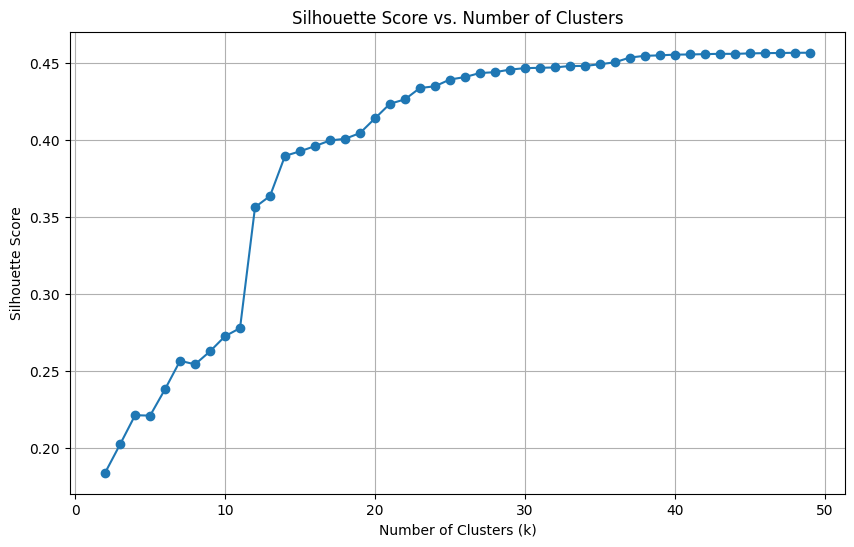

In [6]:
# Parse the AN (algebraic notation) column into move sequences
#chess_df['parsed_moves'] = chess_df['AN'].apply(parse_chess_moves)

# Compute distance matrix from parsed moves
dist_matrix = compute_distance_matrix(chess_df['parsed_moves'].tolist())

sil_scores = []
K_range = range(2, 50)

for k in K_range:
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    labels = model.fit_predict(dist_matrix)
    score = silhouette_score(dist_matrix, labels, metric='precomputed')
    sil_scores.append(score)
    print(f"Silhouette score for k={k}: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, sil_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# MDS embedding (distance to coordinates)
#embedding = MDS(n_components=2,n_jobs = -1, dissimilarity='precomputed', random_state=seed)
#coords = embedding.fit_transform(dist_matrix)
#plot_elbow_method(coords, max_k=16)
#plot_silhouette_scores(coords, max_k=16)

#testing optimal K

In [7]:
#kmeans = KMeans(n_clusters=9, random_state=seed)
#clusters = kmeans.fit_predict(coords)
model = AgglomerativeClustering(n_clusters=17, metric='precomputed', linkage='average')
clusters = model.fit_predict(dist_matrix)
# Add cluster labels to your DataFrame
chess_df['AN_cluster'] = clusters

# Optional: Drop parsed moves if no longer needed
# df_chosen_games = df_chosen_games.drop(columns=['parsed_moves'])

# View results
print(chess_df[['AN', 'AN_cluster']].head())

                                                  AN  AN_cluster
0  1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...          11
1  1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...          14
2  1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....          12
3  1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...           5
4  1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...           3


In [8]:
check_missing_vals(chess_df)

Missing Values Report:



'No columns have missing values.'

In [9]:
#Splitting Total Data, 80% Training Dataset, 20% Holdout Dataset

# First split: 80% training, 20% holdout
training_set, holdout_set = train_test_split(chess_df, test_size=0.2, random_state=seed, stratify=chess_df[target_column])

#Splitting Training data, 80% training, 20% testing
X = training_set.drop(columns=target_column)
y = training_set[target_column]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Calculate row counts and percentages
total_rows = len(X)
train_percentage = (len(X_train) / total_rows) * 100
test_percentage = (len(X_test) / total_rows) * 100

split_report_df = pd.DataFrame({
    'Row Count': [len(X_train), len(X_test)],
    'Percentage of Total': [f"{train_percentage:.2f}%", f"{test_percentage:.2f}%"],
    'Features (X)': [X_train.shape, X_test.shape],
    'Target (y)': [(len(y_train), 1), (len(y_test), 1)]
}, index=['Training Set', 'Holdout Set'])

# Print the report
print("Data Split Report:\n")
print(split_report_df.to_string(index=True, float_format="%.2f"))

Data Split Report:

              Row Count Percentage of Total Features (X) Target (y)
Training Set       6400              80.00%   (6400, 17)  (6400, 1)
Holdout Set        1600              20.00%   (1600, 17)  (1600, 1)


In [10]:
#Remove unneccessary Columns and Restructure certain Columns
drop_cols = ['White','Black','WhiteRatingDiff', 'BlackRatingDiff', 'UTCDate','UTCTime','parsed_moves','AN', 'AN_opening','Termination']
categorical_cols = ['Event', 'ECO','Opening']
quantitative_cols = ['WhiteElo','BlackElo','TimeControl', 'EloDiff','AN_cluster']#,'stockfish_eval']

X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

In [11]:
X_train.head()

,Event,WhiteElo,BlackElo,ECO,Opening,TimeControl,EloDiff,AN_cluster
7265,Classical,1677,1789,B00,Nimzowitsch Defense,480.0,-112,2
761,Blitz,1836,1904,C00,French Defense: Knight Variation,180.0,-68,5
5737,Classical,1251,1421,C44,Scotch Game,600.0,-170,14
6594,Classical,1851,2000,A00,Van't Kruijs Opening,480.0,-149,15
8164,Bullet,1719,1633,C00,French Defense: Knight Variation,120.0,86,14


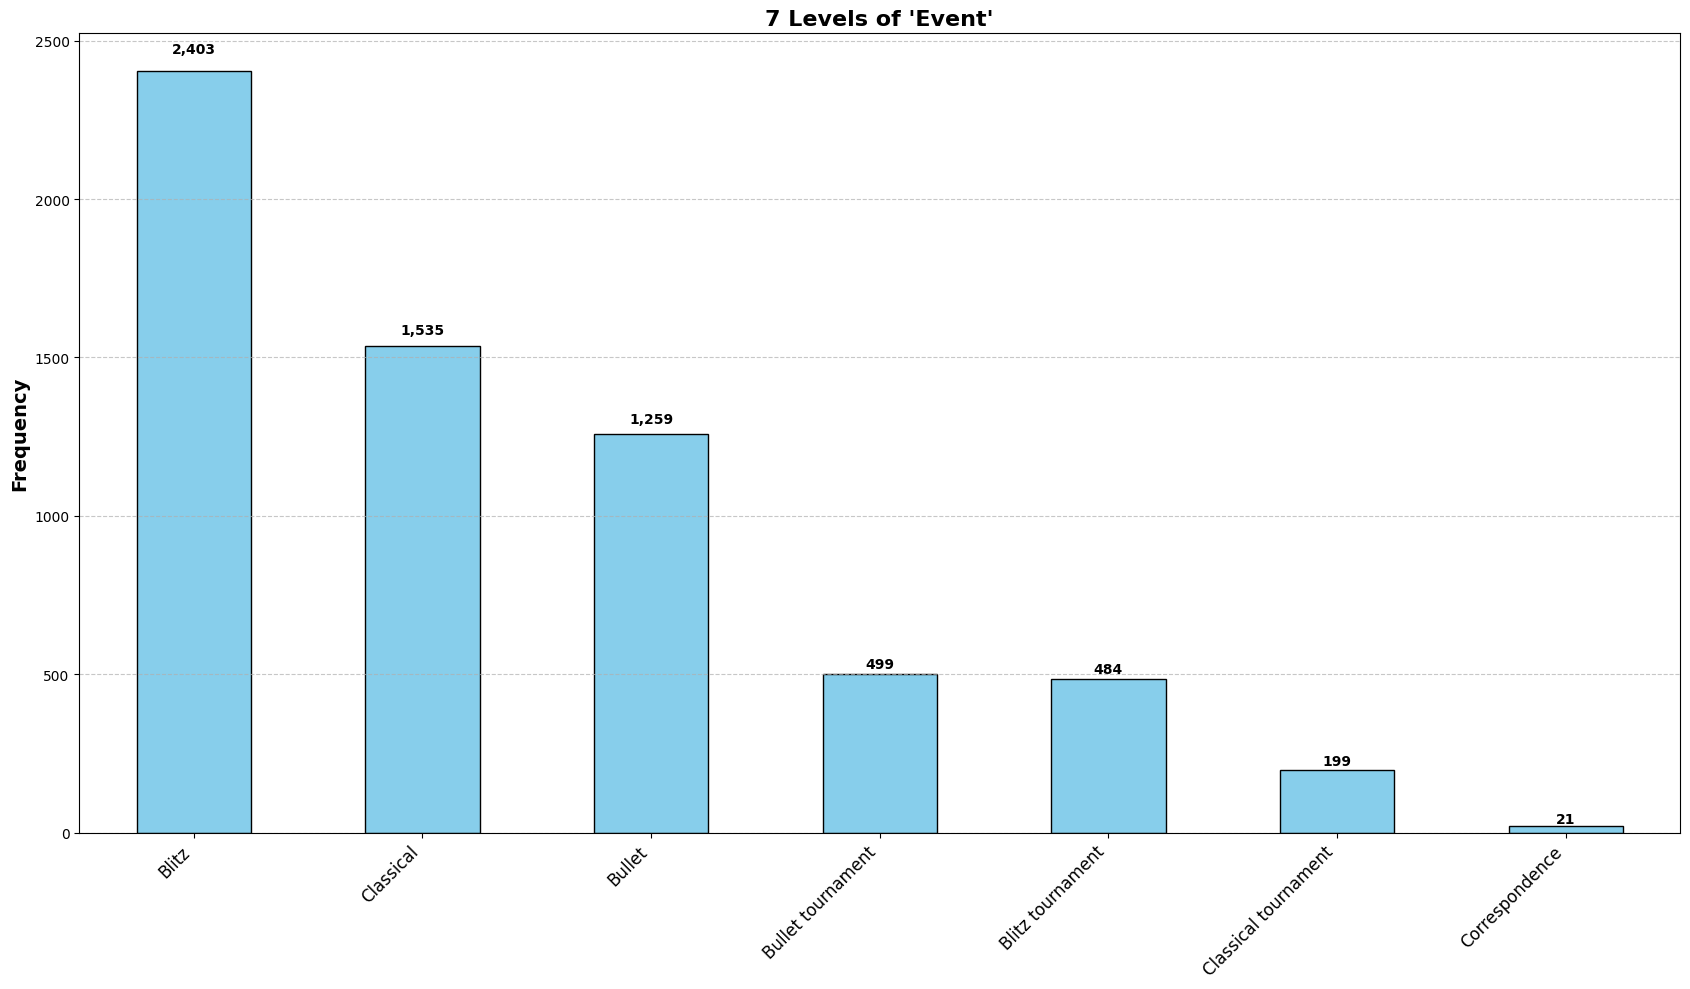

In [12]:
#Bar plot of the top 10 levels of Event, if more than 10 add "other" as a category - show missing values

plot_top_10_levels(X_train,['Event'])

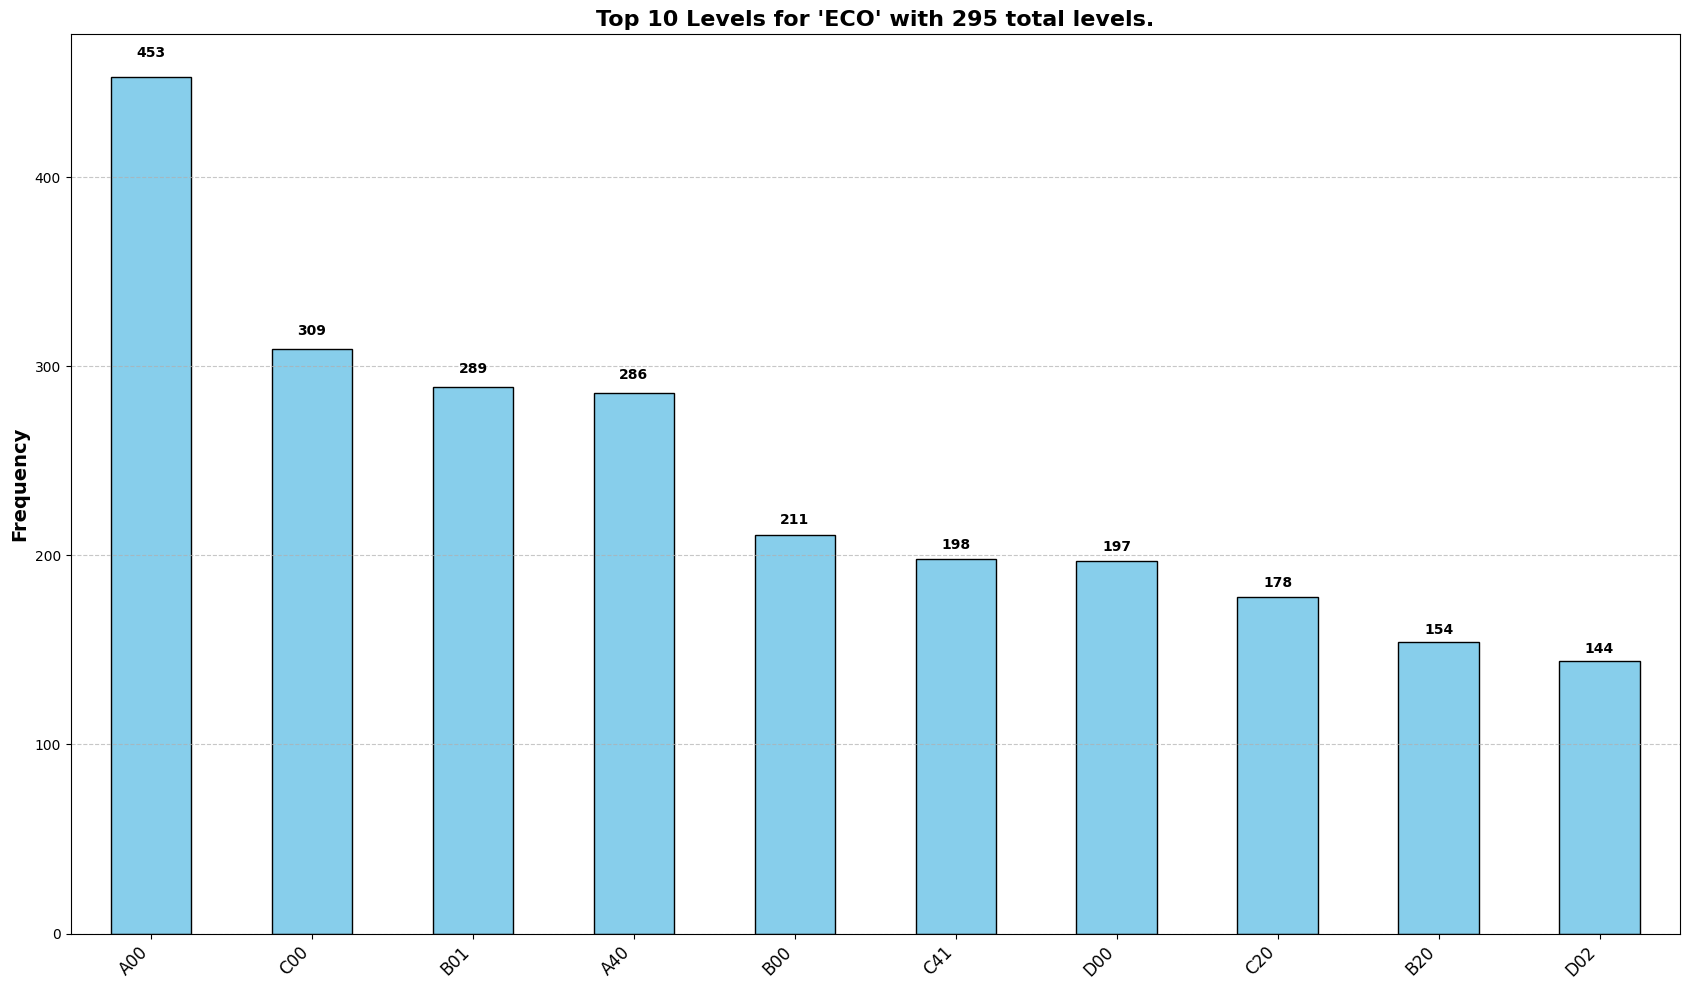

In [13]:
#Bar plot of the top 10 levels of ECO, if more than 10 add "other" as a category - show missing values
plot_top_10_levels(X_train,['ECO'])

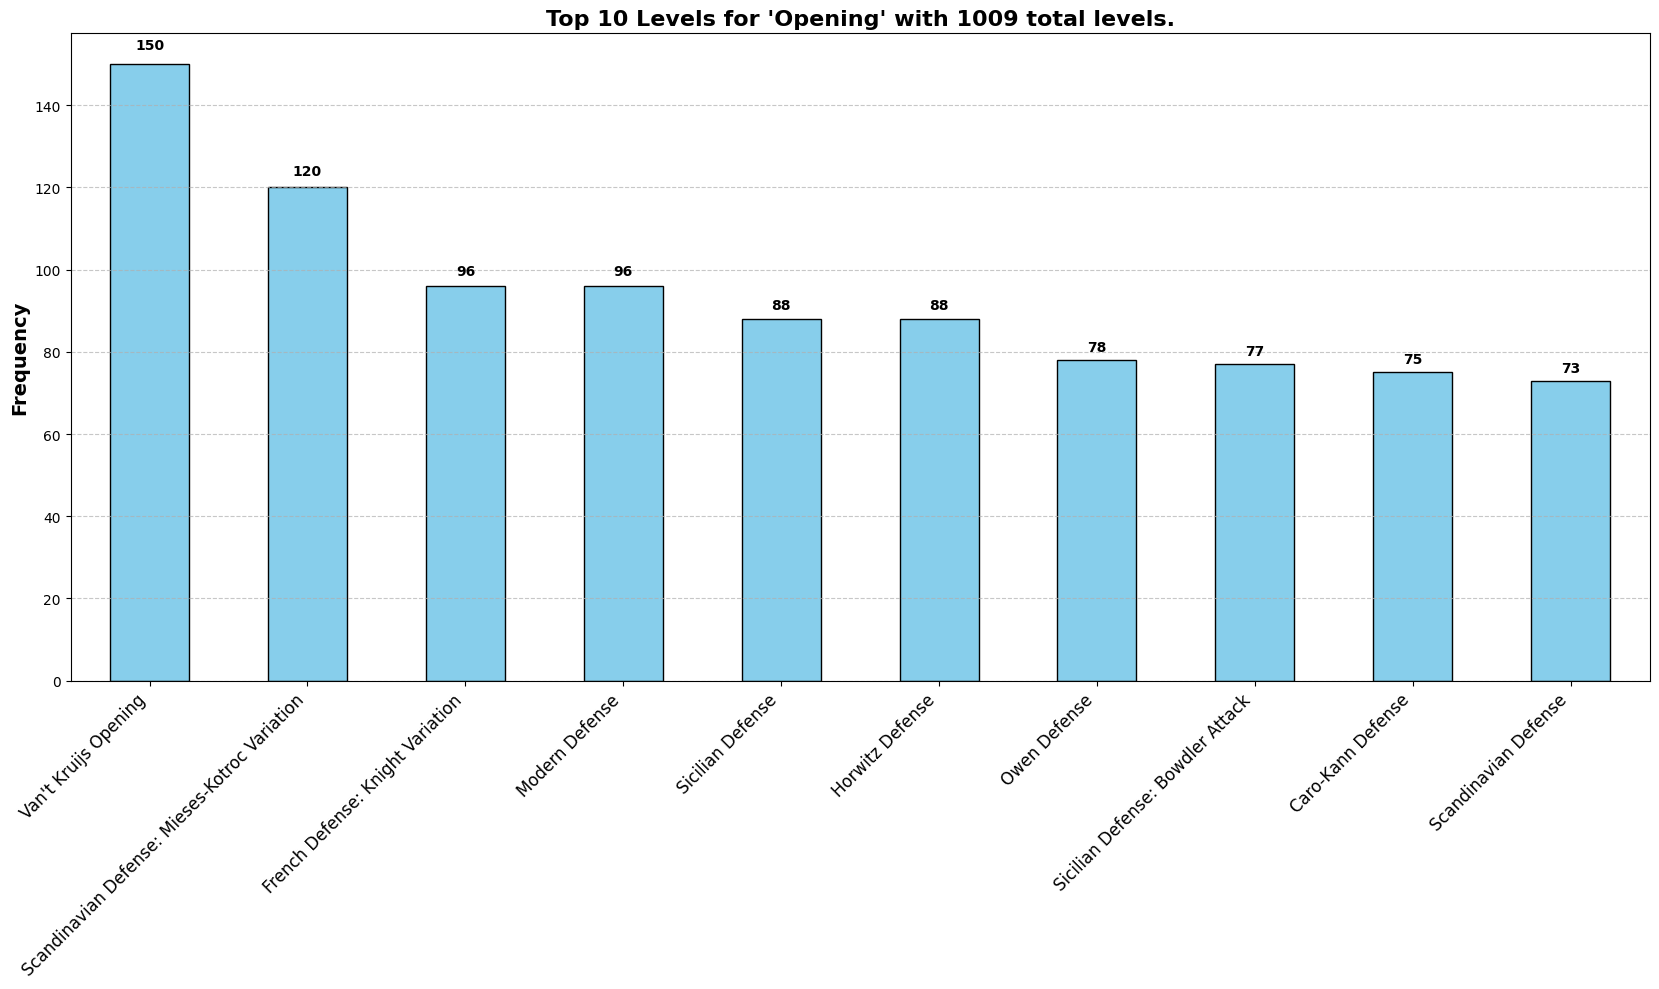

In [14]:
#Bar plot of the top 10 levels of Opening, if more than 10 add "other" as a category - show missing values
plot_top_10_levels(X_train,['Opening'])

Six-Number Summary:
  Statistic   Value
        Min  846.00
   Q1 (25%) 1547.75
Median (Q2) 1724.50
   Q3 (75%) 1901.00
        Max 2628.00
       Mean 1727.80

No negative values detected


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


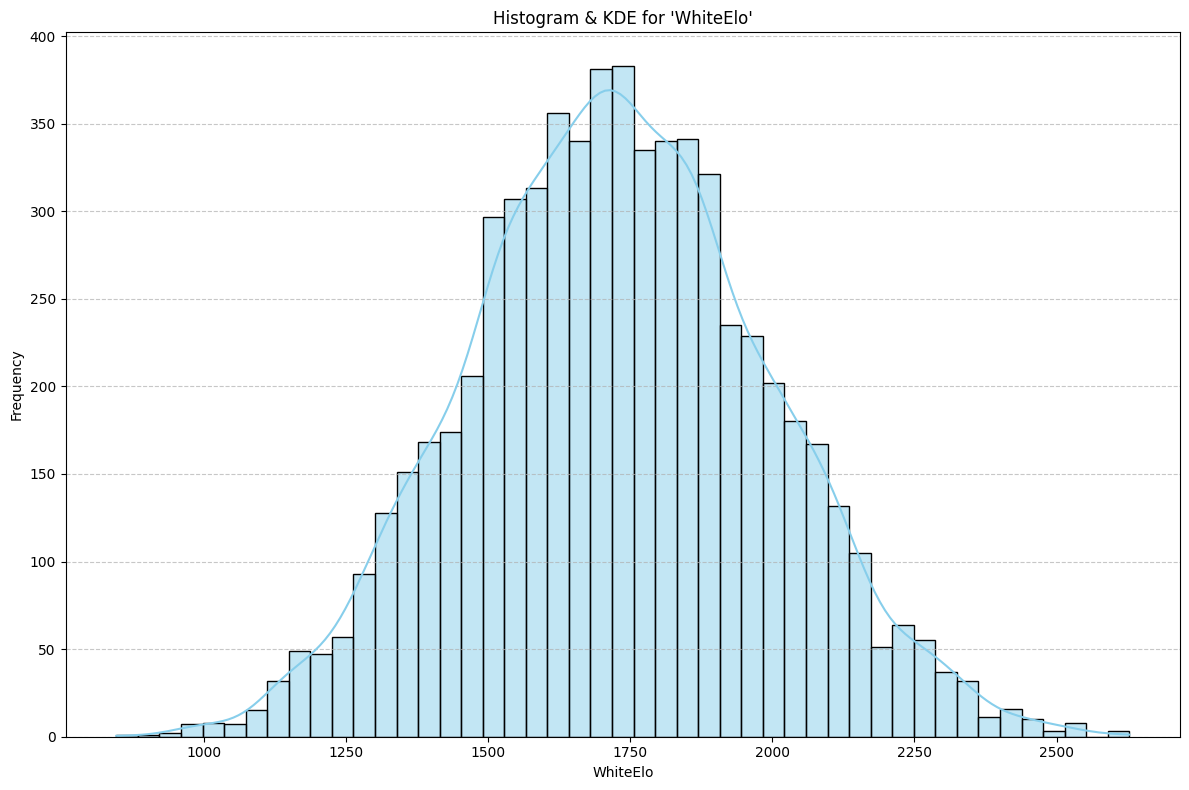

In [15]:
#Histogram plot of WhiteElo, might need to log-mod or use a kernal density estimator, show 6-number summary (min,q1,q2,q3,max,mean)
analyze_quantitative_column(X_train, 'WhiteElo')

Six-Number Summary:
  Statistic   Value
        Min  877.00
   Q1 (25%) 1544.75
Median (Q2) 1722.00
   Q3 (75%) 1896.00
        Max 2623.00
       Mean 1725.90

No negative values detected


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


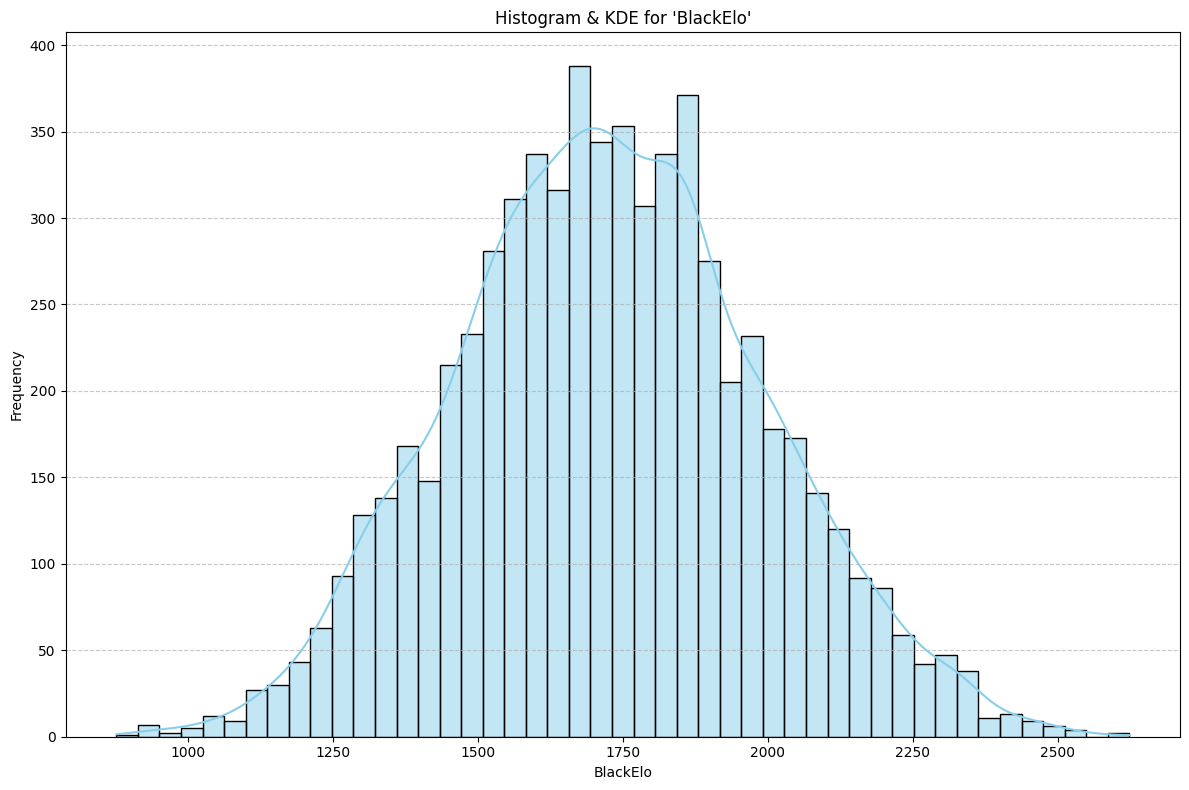

In [16]:
#Histogram plot of BlackElo, might need to log-mod or use a kernal density estimator, show 6-number summary (min,q1,q2,q3,max,mean)
analyze_quantitative_column(X_train, 'BlackElo')

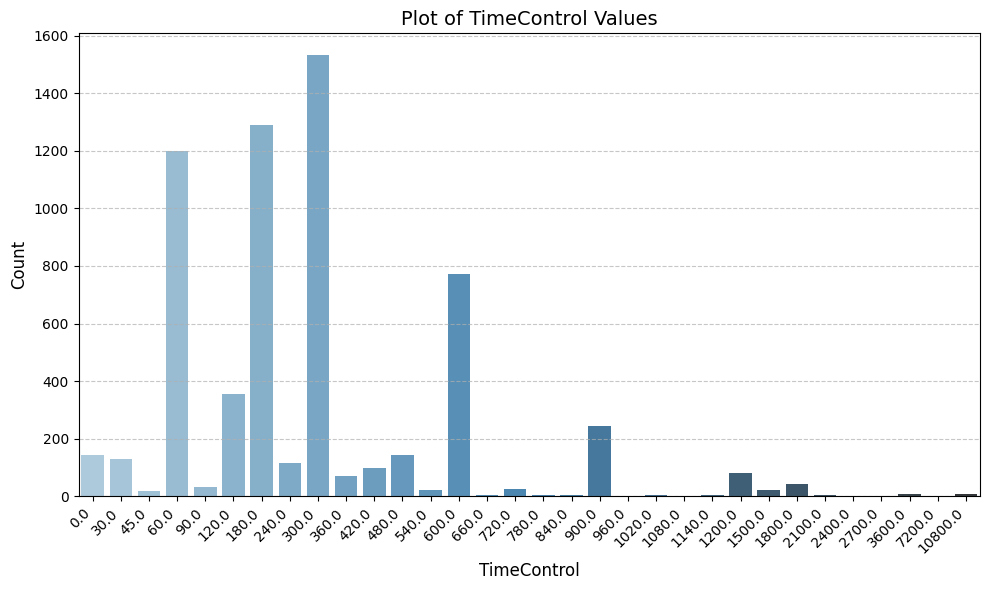

In [17]:
#Histogram plot of TimeControl, might need to log-mod or use a kernal density estimator, show 6-number summary (min,q1,q2,q3,max,mean)
#analyze_quantitative_column(X_new, 'TimeControl')
def plot_timecontrol_countplot(df, column='TimeControl'):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, palette="Blues_d")
    plt.title(f"Plot of TimeControl Values", fontsize=14)
    plt.xlabel("TimeControl", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Assuming you have the 'TimeControl' column
plot_timecontrol_countplot(X_train)

Analysis for 'AN_cluster':
Total Rows: 6400
Missing Values: 0 (0.00%)

Six-Number Summary:
  Statistic  Value
        Min   0.00
   Q1 (25%)   4.00
Median (Q2)  11.00
   Q3 (75%)  14.00
        Max  16.00
       Mean   8.68

No negative values detected


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


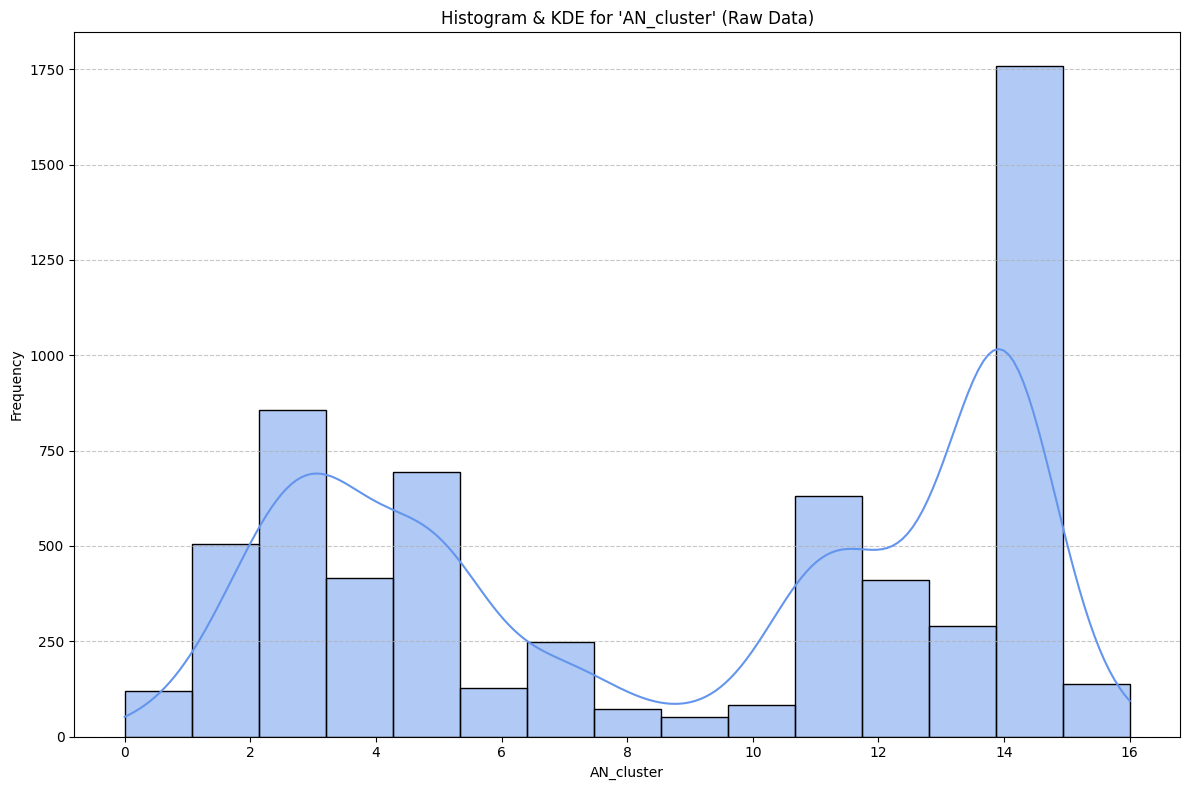

In [18]:
#Histogram plot of stockfish_eval_white, might need to log-mod or use a kernal density estimator, show 6-number summary (min,q1,q2,q3,max,mean)
analyze_quantitative_column_raw(X_train, 'AN_cluster')

In [19]:
# Encode target variable
y_train = y_train.map({'1-0': 1, '0-1': 0, '1/2-1/2': -1})
y_test = y_test.map({'1-0': 1, '0-1': 0, '1/2-1/2': -1})

# Check for any NaNs caused by mapping unexpected values
print("y_train unique values:", y_train.unique())
print("Any NaNs in y_train:", y_train.isna().any())
print("number of nans:", y_train.isna().sum())

from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

# Get unique class labels
classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

# Initialize CatBoost classifier
cat_model = CatBoostClassifier(iterations=5000, depth=8, learning_rate=0.01, cat_features=categorical_cols, verbose=100,class_weights=list(class_weights_dict.values()))

# Train the model
cat_model.fit(X_train, y_train)

# Make predictions
y_pred = cat_model.predict(X_test)

y_train unique values: [0 1]
Any NaNs in y_train: False
number of nans: 0
0:	learn: 0.6916284	total: 64.5ms	remaining: 5m 22s
100:	learn: 0.6214525	total: 1s	remaining: 48.8s
200:	learn: 0.6030636	total: 1.92s	remaining: 45.7s
300:	learn: 0.5906648	total: 2.85s	remaining: 44.4s
400:	learn: 0.5804363	total: 3.79s	remaining: 43.4s
500:	learn: 0.5707600	total: 4.72s	remaining: 42.4s
600:	learn: 0.5613370	total: 5.65s	remaining: 41.3s
700:	learn: 0.5515744	total: 6.58s	remaining: 40.3s
800:	learn: 0.5427187	total: 7.49s	remaining: 39.2s
900:	learn: 0.5330241	total: 8.44s	remaining: 38.4s
1000:	learn: 0.5226409	total: 9.44s	remaining: 37.7s
1100:	learn: 0.5125195	total: 10.4s	remaining: 36.9s
1200:	learn: 0.5036495	total: 11.4s	remaining: 36.1s
1300:	learn: 0.4948586	total: 12.4s	remaining: 35.2s
1400:	learn: 0.4863401	total: 13.4s	remaining: 34.4s
1500:	learn: 0.4776596	total: 14.4s	remaining: 33.6s
1600:	learn: 0.4697133	total: 15.4s	remaining: 32.7s
1700:	learn: 0.4612536	total: 16.4s	re

In [20]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6438
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.63      0.63       776
           1       0.65      0.66      0.66       824

    accuracy                           0.64      1600
   macro avg       0.64      0.64      0.64      1600
weighted avg       0.64      0.64      0.64      1600



In [21]:
#Splitting Training data, 80% training, 20% testing
X_hold = holdout_set.drop(columns=target_column)
y_hold = holdout_set[target_column]

X_hold = X_hold.drop(columns=drop_cols, errors='ignore')
y_hold = y_hold.drop(columns=drop_cols, errors='ignore')

y_hold = y_hold.map({'1-0': 1, '0-1': 0, '1/2-1/2': -1})
# Make predictions on the holdout set
y_pred_hold = cat_model.predict(X_hold)

# Calculate the number of correct predictions and total predictions
correct_predictions = (y_pred_hold == y_hold).sum()
total_predictions = len(y_pred_hold)

# # Display list of predictions with actual values
# print(f"Predictions vs Actual values (True vs Predicted):")
# for true, pred in zip(y_hold, y_pred_hold):
#     print(f"True: {true}, Predicted: {pred}")
    
# Output the results
print(f"Correct predictions: {correct_predictions} out of {total_predictions}, {correct_predictions/total_predictions}")

Correct predictions: 1278 out of 2000, 0.639


0:	learn: 0.6913231	total: 11.3ms	remaining: 56.3s
100:	learn: 0.6169413	total: 909ms	remaining: 44.1s
200:	learn: 0.5949668	total: 1.82s	remaining: 43.4s
300:	learn: 0.5791178	total: 2.74s	remaining: 42.8s
400:	learn: 0.5660418	total: 3.65s	remaining: 41.9s
500:	learn: 0.5547923	total: 4.55s	remaining: 40.8s
600:	learn: 0.5438884	total: 5.42s	remaining: 39.6s
700:	learn: 0.5323400	total: 6.37s	remaining: 39s
800:	learn: 0.5213386	total: 7.47s	remaining: 39.2s
900:	learn: 0.5090643	total: 8.5s	remaining: 38.7s
1000:	learn: 0.4970568	total: 9.44s	remaining: 37.7s
1100:	learn: 0.4856289	total: 10.4s	remaining: 36.7s
1200:	learn: 0.4745610	total: 11.3s	remaining: 35.8s
1300:	learn: 0.4643872	total: 12.3s	remaining: 34.8s
1400:	learn: 0.4543703	total: 13.2s	remaining: 33.9s
1500:	learn: 0.4450423	total: 14.2s	remaining: 33s
1600:	learn: 0.4346336	total: 15.1s	remaining: 32.1s
1700:	learn: 0.4256481	total: 16.1s	remaining: 31.1s
1800:	learn: 0.4173429	total: 17s	remaining: 30.2s
1900:	learn

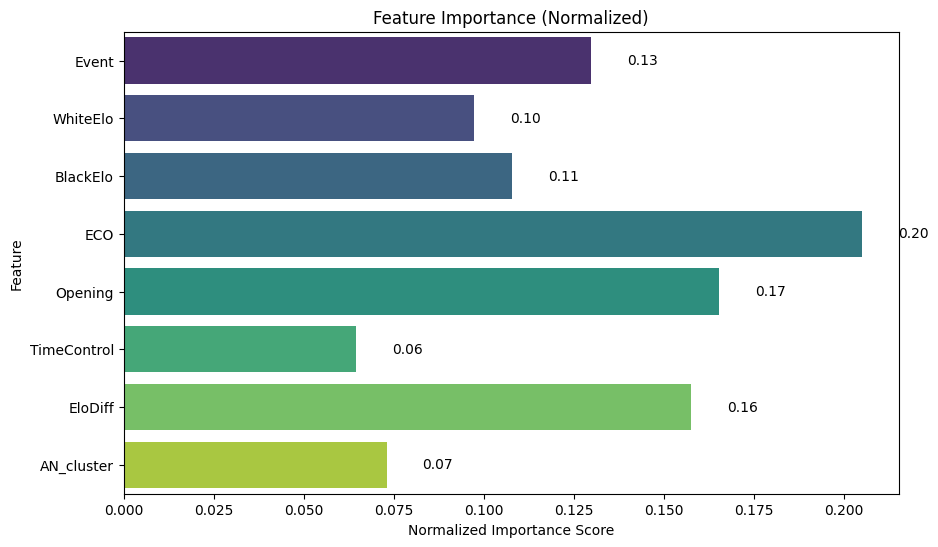

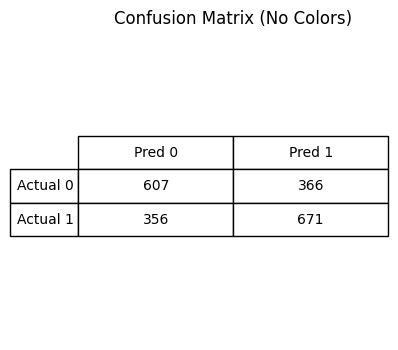

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Import SHAP for explainability
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Cross-validation using K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring="accuracy")

# Accuracy on the holdout set
accuracy = accuracy_score(y_hold, y_pred_hold)

# Precision, recall, F1-score
precision = precision_score(y_hold, y_pred_hold, average='weighted')
f1 = f1_score(y_hold, y_pred_hold, average='weighted')

# AUC-ROC for binary classification
auc_roc = roc_auc_score(y_hold, cat_model.predict_proba(X_hold)[:, 1])

metrics = {
    "Metric": ["Cross-Validation Accuracy", "Test Accuracy", "Precision", "F1 Score", "AUC-ROC"],
    "Value": [cv_scores.mean(), accuracy, precision, f1, auc_roc]
}

df = pd.DataFrame(metrics)
print(df.to_string(index=False))

# Get original feature importances and normalize them
feature_importances = cat_model.feature_importances_
normalized_importances = feature_importances / np.sum(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=normalized_importances, y=X_train.columns, palette="viridis")

# Add annotations at the end of bars
for index, value in enumerate(normalized_importances):
    ax.text(value + 0.01, index, f"{value:.2f}", va="center")  # Adjust position slightly for normalized values

plt.title("Feature Importance (Normalized)")
plt.xlabel("Normalized Importance Score")
plt.ylabel("Feature")
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_hold, y_pred_hold)

# Create figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table and add values
table = plt.table(cellText=cm, 
                  cellLoc='center', 
                  loc='center', 
                  rowLabels=["Actual 0", "Actual 1"], 
                  colLabels=["Pred 0", "Pred 1"])

table.scale(1, 2)  # Adjust size of cells

plt.title("Confusion Matrix (No Colors)")
plt.show()

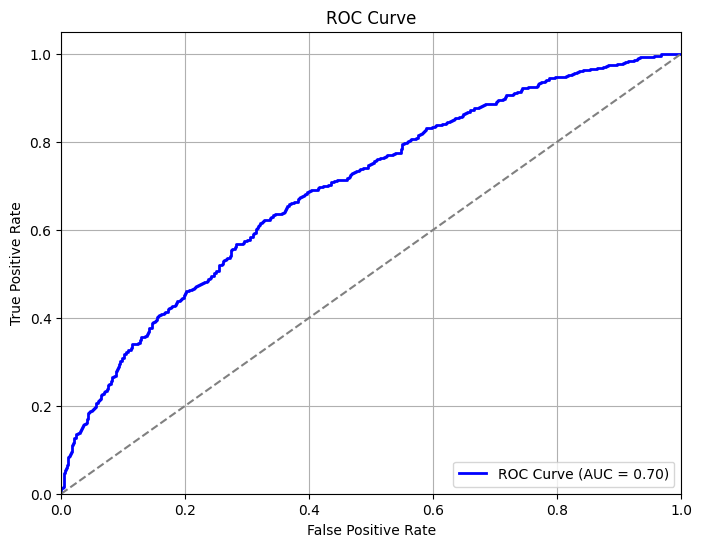

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probability estimates for the positive class (class 1)
y_probs = cat_model.predict_proba(X_test)[:, 1]  # Assuming a binary classification problem

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

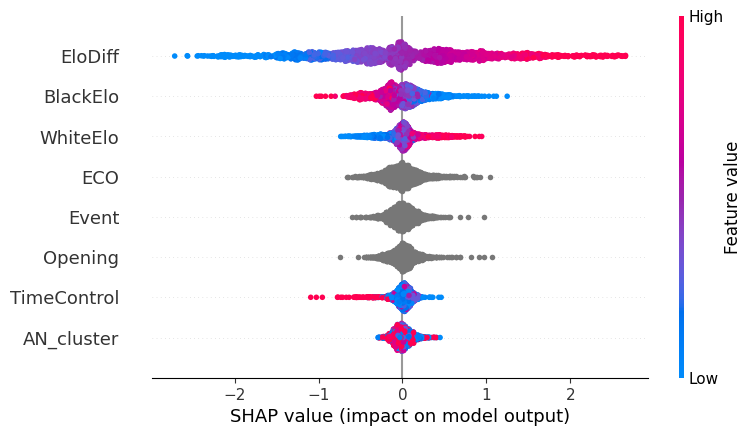

In [24]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer
explainer = shap.TreeExplainer(cat_model)

# Compute SHAP values
shap_values = explainer(X_hold)  # This returns an Explanation object

# Ensure SHAP values exist before plotting
if shap_values is not None:
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(shap_values)
    #plt.title("SHAP Beeswarm Plot")
    plt.show()
else:
    print("SHAP values are empty! Check model predictions and input data.")

In [25]:
"""###############################################################################################
def divergence_ply(seq1, seq2):
   """ """
    Counts the total number of differing plies (half-moves) between two sequences.
    Includes differences due to unequal lengths.
    """"""
    min_len = min(len(seq1), len(seq2))
    #min_len = min(len(seq1),len(seq2))
    #np.sum(seq1[0:min_len] != seq2[0:min_len])
    #Boolean_series = (seq1[0:min_len] != seq2[0:min_len]

    for i in range(min_len):
        move1 = seq1[i]
        move2 = seq2[i]
        if move1 != move2 #np.sum(seq1[0:min_len] != seq2[0:min_len]):
            return i+1
    return min_len

def compute_distance_matrix(parsed_moves):
    """"""
    Computes a distance matrix based on how early sequences diverge.
    D(seq1, seq2) = 1 / (n^2 + 1) where n is the first ply where they differ.
    """"""
    n = len(parsed_moves)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            n_div = divergence_ply(parsed_moves[i], parsed_moves[j])
            dist = 1 / (n_div^2)
            dist_matrix[i][j] = dist
            dist_matrix[j][i] = dist
        if i%1000 == 0:
            print('we are on ', i, ' row number.')
    return dist_matrix
###############################################################################################

# Compute distance matrix from parsed moves
dist_matrix = compute_distance_matrix(chess_df['parsed_moves'].tolist())

# MDS embedding (distance to coordinates)
embedding = MDS(n_components=2,n_jobs = -1, dissimilarity='precomputed', random_state=seed)
#print("finished embedding.")
coords = embedding.fit_transform(dist_matrix)
#print("finished coords.")

# KMeans clustering based on embedded coordinates
kmeans = KMeans(n_clusters=8, random_state=seed)
#print("finished kmeans.")
clusters = kmeans.fit_predict(coords)
#print("finished clusters.")

# Add cluster labels to your DataFrame
chess_df['AN_cluster'] = clusters

# Optional: Drop parsed moves if no longer needed
# df_chosen_games = df_chosen_games.drop(columns=['parsed_moves'])

# View results
print(chess_df[['AN', 'AN_cluster']].head())
"""

'###############################################################################################\ndef divergence_ply(seq1, seq2):\n   \n    Counts the total number of differing plies (half-moves) between two sequences.\n    Includes differences due to unequal lengths.\n    \n    min_len = min(len(seq1), len(seq2))\n    #min_len = min(len(seq1),len(seq2))\n    #np.sum(seq1[0:min_len] != seq2[0:min_len])\n    #Boolean_series = (seq1[0:min_len] != seq2[0:min_len]\n\n    for i in range(min_len):\n        move1 = seq1[i]\n        move2 = seq2[i]\n        if move1 != move2 #np.sum(seq1[0:min_len] != seq2[0:min_len]):\n            return i+1\n    return min_len\n\ndef compute_distance_matrix(parsed_moves):\n    \n    Computes a distance matrix based on how early sequences diverge.\n    D(seq1, seq2) = 1 / (n^2 + 1) where n is the first ply where they differ.\n    \n    n = len(parsed_moves)\n    dist_matrix = np.zeros((n, n))\n    for i in range(n):\n        for j in range(i + 1, n):\n       